In [1]:
import altair as alt
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from pathlib import Path

alt.renderers.enable('jupyterlab')

%config InlineBackend.figure_format = 'retina'

## Data visualization and error analysis

In [2]:
def read_file(file, dist=np.nan):
    data = []
    df = pd.read_csv(file, header=None)
    for _, (t, v, us) in df.iterrows():
        data.append((t, dist, 1/v, us))
    return pd.DataFrame(data, columns=["t", "dist", "IR", 'Ultrasound'])
    
def read_experiment_data(exp_folder: Path):
    data = []
    files = sorted(list(map(lambda x: (int(x.name.split('_')[1].split('.')[0]), x), list(exp_folder.glob('*.csv')))))

    for dist, file in files:
        data.append(read_file(file, dist))
    return pd.concat(data).reset_index(drop=True)
            
df_1 = read_experiment_data(Path('exp_1/'))
df_2 = read_experiment_data(Path('exp_2/'))
df = pd.concat([df_1, df_2])

In [3]:
def visualize_results(df, sensor):
    return (alt.Chart(df).encode(
        x=alt.X('dist:Q', title='Distance, cm'),
        y=alt.Y(f'min({sensor}):Q', scale=alt.Scale(zero=False), title='Boxplot, mV' if sensor == 'IR' else 'Boxplot, cm'),
        y2=f'max({sensor}):Q',
        tooltip=['dist', f'min({sensor})', f'max({sensor})']
    ).mark_rule() + alt.Chart(df).encode(
        x='dist:Q',
        y=f'median({sensor}):Q',
        tooltip=['dist', f'min({sensor})', f'max({sensor})']
    ).mark_point(size=1)).properties(
        title=f'Correspondence between distance and {sensor} measurements'
    )

/opt/homebrew/lib/python3.10/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


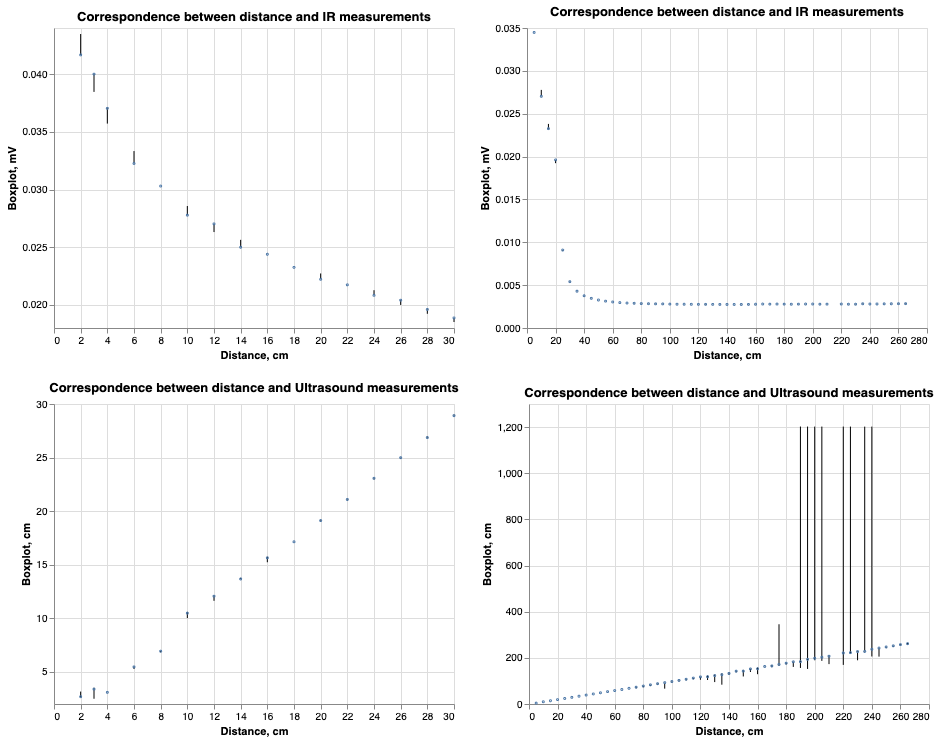

In [4]:
(
    (visualize_results(df_1, 'IR') | visualize_results(df_2, 'IR'))
    &
    (visualize_results(df_1, 'Ultrasound') | visualize_results(df_2, 'Ultrasound'))
)

## Calibration

/opt/homebrew/lib/python3.10/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


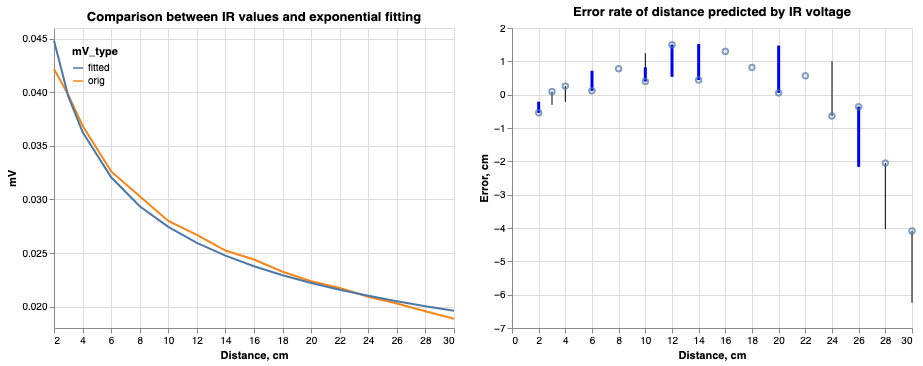

In [6]:
dist = df_1['dist'].values
mv = df_1['IR'].values

a,b = np.polyfit(np.log(dist), np.log(mv), deg=1)

pred_mv = np.exp(b + a*np.log(dist))

pred_dist = np.exp((np.log(mv) - b)/a)

int_df = pd.DataFrame({'dist_orig': dist, 'mv_orig': mv, 'mv_fitted': pred_mv, 'dist_pred': pred_dist}).reset_index()
int_df_mv = pd.wide_to_long(int_df, stubnames='mv', i=['index', 'dist_orig', 'dist_pred'], j='mV_type', sep='_', suffix=r'\w+').reset_index()

int_df['err'] = int_df['dist_orig'] - int_df['dist_pred']
group = int_df.groupby('dist_orig')
stats_df = pd.DataFrame({"min_err": group.min()['err'], 
                         "max_err": group.max()['err'],  
                         "mean_err": group.mean()['err'], 
                         "median_err": group.quantile(0.5)['err'],
                         "quantile_25_err": group.quantile(0.25)['err'],
                         "quantile_75_err": group.quantile(0.75)['err']
                        }).reset_index()

base =  alt.Chart(stats_df).encode(
        x=alt.X('dist_orig', title='Distance, cm'),
)

(
    alt.Chart(int_df_mv).encode(
        x=alt.X('dist_orig', title='Distance, cm'),
        y=alt.Y('mean(mv):Q', scale=alt.Scale(zero=False), title='mV'),
        color=alt.Color('mV_type', legend=alt.Legend(orient='top-left'))
    ).mark_line().properties(title='Comparison between IR values and exponential fitting') |
    
    (
        base.encode(
            y=alt.Y('min_err:Q', scale=alt.Scale(zero=False), title='Error, cm'),
            y2=alt.Y2('max_err:Q'),
        ).mark_rule() + 
        base.encode(
            y=alt.Y('quantile_25_err:Q', scale=alt.Scale(zero=False), title='Error, cm'),
            y2=alt.Y2('quantile_75_err:Q',),
        ).mark_rule(strokeWidth=3, color='blue') +
        base.encode(
            y=alt.Y('median_err:Q', scale=alt.Scale(zero=False), title='Error, cm'),
        ).mark_point()
    ).properties(title='Error rate of distance predicted by IR voltage')
)

/var/folders/4k/g9fmxr415sb_6r09m23q8p8m0000gn/T/ipykernel_77704/3686289696.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['diff'] = train_df['Ultrasound'] - train_df['dist']
/opt/homebrew/lib/python3.10/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


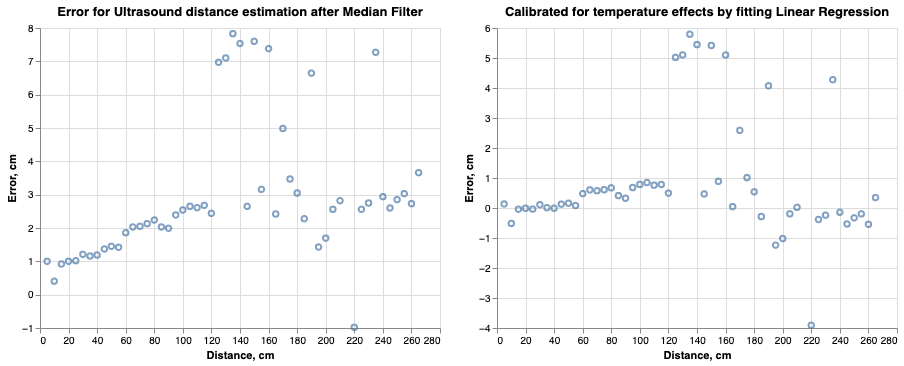

In [8]:
from sklearn.linear_model import LinearRegression

# Using median filter
int_df = df_2.groupby('dist').median().reset_index()

train_df = df_2[(df_2.dist >= 20) & (df_2.dist <= 40)]
train_df['diff'] = train_df['Ultrasound'] - train_df['dist']

model = LinearRegression()
model.fit(train_df['dist'].values.reshape(-1, 1), train_df['diff'].values)

diff_pred = model.predict(int_df['Ultrasound'].values.reshape(-1, 1))
int_df['Ultrasound_calibrated'] =  int_df['Ultrasound'] - diff_pred 
int_df['err'] = int_df['dist'] - int_df['Ultrasound']

def visualize_error(int_df, title=''):
    group = int_df.groupby('dist')
    stats_df = pd.DataFrame({"min_err": group.min()['err'], 
                             "max_err": group.max()['err'],  
                             "mean_err": group.mean()['err'], 
                             "median_err": group.quantile(0.5)['err'],
                             "quantile_25_err": group.quantile(0.25)['err'],
                             "quantile_75_err": group.quantile(0.75)['err']
                            }).reset_index()

    base =  alt.Chart(stats_df).encode(
            x=alt.X('dist', title='Distance, cm'),
            tooltip='dist'
    )

    return (
        base.encode(
            y=alt.Y('min_err:Q', scale=alt.Scale(zero=False), title='Error, cm'),
            y2=alt.Y2('max_err:Q'),
        ).mark_rule() + 
        base.encode(
            y=alt.Y('quantile_25_err:Q', scale=alt.Scale(zero=False), title='Error, cm'),
            y2=alt.Y2('quantile_75_err:Q',),
        ).mark_rule(strokeWidth=3, color='blue') +
        base.encode(
            y=alt.Y('median_err:Q', scale=alt.Scale(zero=False), title='Error, cm'),
        ).mark_point()
    ).properties(title=title)

int_df_calibrated = int_df.copy()
int_df_calibrated['err'] = int_df['dist'] - int_df['Ultrasound_calibrated']

visualize_error(int_df, 'Error for Ultrasound distance estimation after Median Filter') | visualize_error(int_df_calibrated, title='Calibrated for temperature effects by fitting Linear Regression')

## Dynamic Scenario

In [9]:
df = read_file('exp_3/data_kalman_2.csv')

# Fixup timestemp 
ts_vals = (df['t'].iloc[1:].values - df['t'].iloc[:-1].values)
df['t'].iloc[1:] = np.clip(ts_vals, np.quantile(ts_vals, 0.02), np.quantile(ts_vals, 0.98)).cumsum()
df['t'] /= 1000

ts_dist = pd.read_csv('exp_3/kalman2_video_timestamps.csv', parse_dates=[1])
ts_dist.Time = pd.to_datetime(ts_dist.Time)
df.t = pd.to_datetime(df.t + 2 + ts_dist.iloc[0].Time.timestamp(), unit='s')

df = pd.merge_asof(df, ts_dist, left_on='t', right_on='Time', tolerance=pd.Timedelta(0.5, unit='s')).drop(columns=['dist', 'Time'])
df['dist'] = df['distance']
df.drop(columns=['distance'], inplace=True)
df['dist'] = df.set_index('t')['dist'].astype(np.float32).interpolate(method='time').values * 100
df['Ultrasound_calibrated'] = df['Ultrasound'] - model.predict(df['Ultrasound'].values.reshape(-1, 1))

In [10]:
df = df.iloc[:-7]

RMSE for Ultrasound after constant velocity KF: 6.54


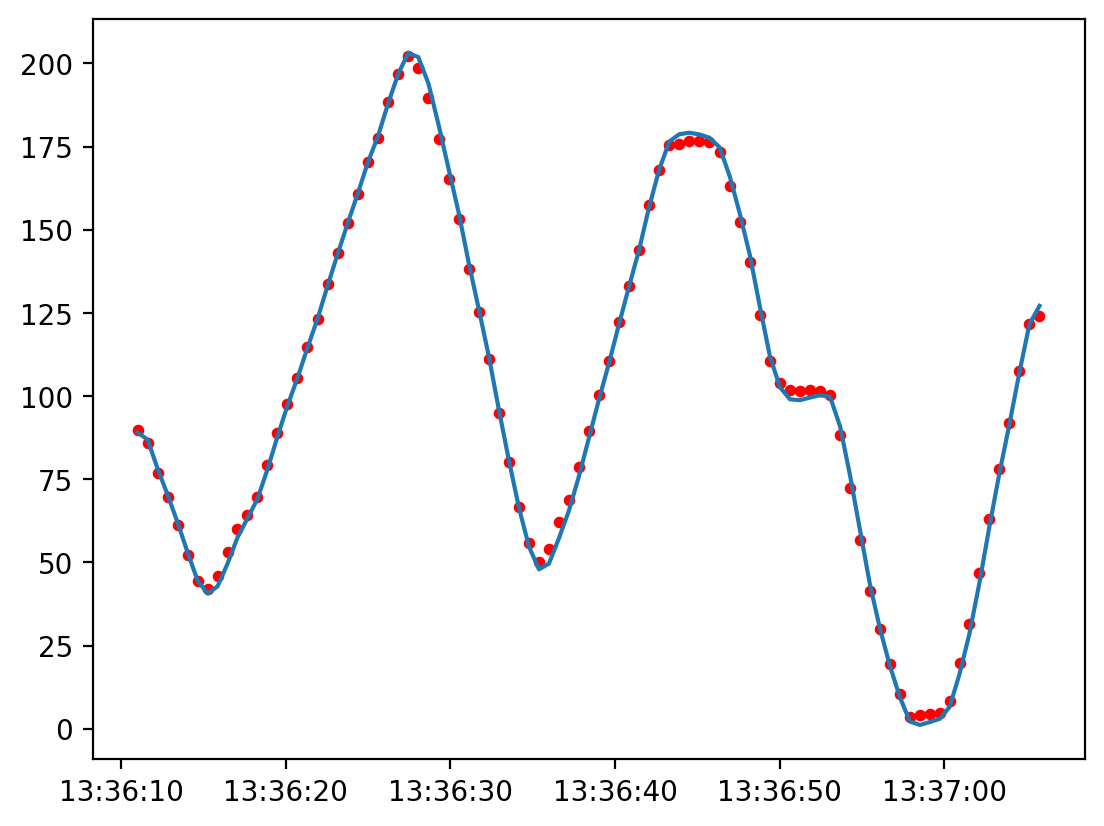

In [11]:
dt_s = df.t.diff(1).mean().microseconds/10**6

from filterpy.kalman import KalmanFilter as KF
import numpy as np
import matplotlib.pyplot as plt

kf = KF(2,1)

kf.F = np.array([[1,dt_s],    # State Transition Model
                 [0,1]])

kf.H = np.array([[1,0]])   # Measurement Model
kf.x = np.array([[0],[0]]) # Initial state
kf.P *= 50                  # State Uncertainty (diag) 
kf.R *= 0.5                  # Measurement Noise (diag)
kf.Q *= 0.4                  # Process Noise     (diag)

T = df.t
M = []
kf_filtered = []

for val in df.Ultrasound_calibrated:
    kf.predict()

    M.append(val)

    kf.update(val)
    kf_filtered.append(kf.x[0,0])

err_3 = np.sqrt(((df['dist'] - kf_filtered)**2).mean())
print(f"RMSE for Ultrasound after constant velocity KF: {err_3:.2f}")

plt.scatter(T,M,c='red',s=10)
plt.plot(T,kf_filtered)
plt.show()

RMSE for Ultrasound after median filter: 7.08
RMSE for Ultrasound after temperature calibration: 6.81
RMSE for Ultrasound after constant velocity KF: 6.54


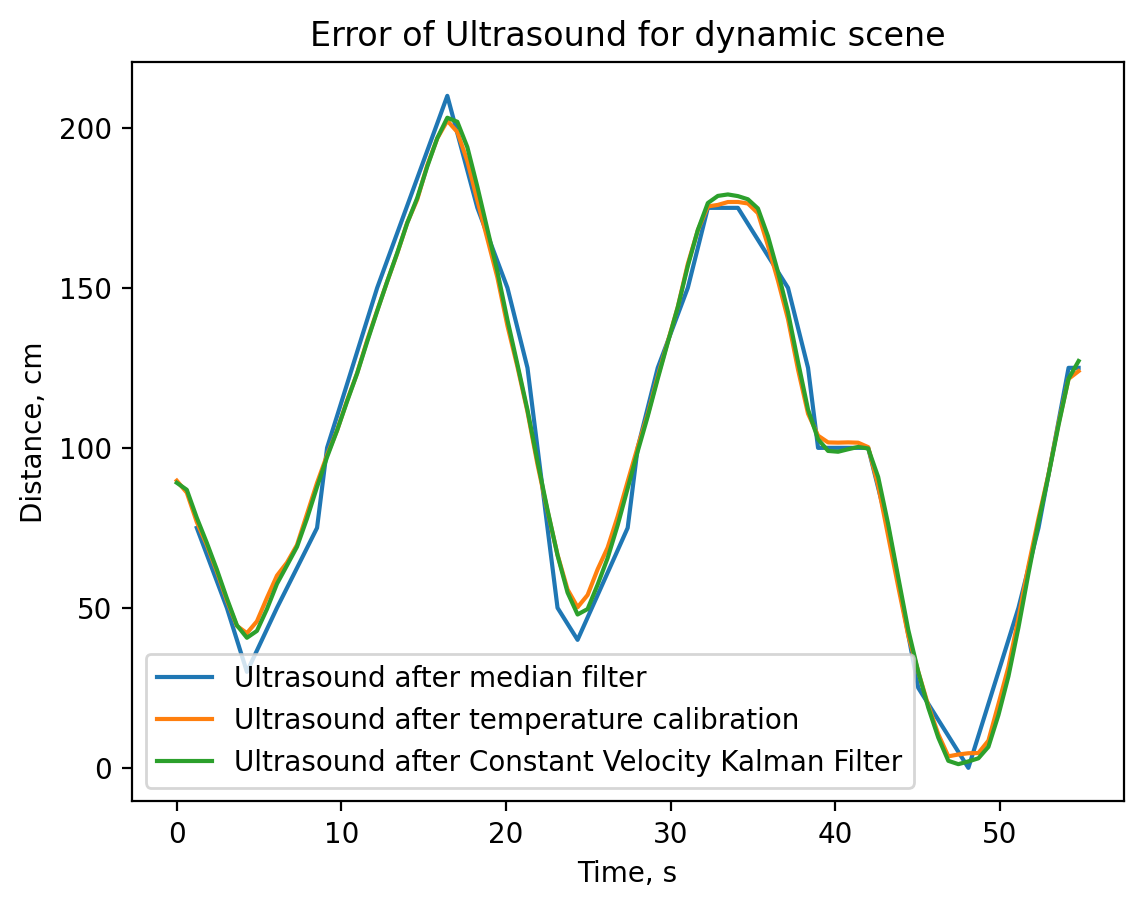

In [12]:
t = np.arange(0, len(df['dist']))*dt_s

plt.plot(t, df['dist'], label='Ultrasound after median filter')
plt.plot(t, df['Ultrasound_calibrated'], label='Ultrasound after temperature calibration')
plt.plot(t, kf_filtered, label='Ultrasound after Constant Velocity Kalman Filter')
plt.title("Error of Ultrasound for dynamic scene")
plt.ylabel("Distance, cm")
plt.xlabel("Time, s")
plt.legend()

err_1 = np.sqrt(((df['dist'] - df['Ultrasound'])**2).mean())
err_2 = np.sqrt(((df['dist'] - df['Ultrasound_calibrated'])**2).mean())
err_3 = np.sqrt(((df['dist'] - kf_filtered)**2).mean())
print(f"RMSE for Ultrasound after median filter: {err_1:.2f}")
print(f"RMSE for Ultrasound after temperature calibration: {err_2:.2f}")
print(f"RMSE for Ultrasound after constant velocity KF: {err_3:.2f}")


## Save video of dynamic scenario

In [17]:
import cv2
from tqdm import tqdm

cap = cv2.VideoCapture('exp_3/episode_2.mov')

frames = []

while True:
    ret, frame = cap.read()
    if not ret:
        break
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frames.append(frame)

In [18]:
frames_m = []

for i, frame in enumerate(tqdm(frames)):
    from matplotlib.figure import Figure
    from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
    import matplotlib

    matplotlib.rcParams['figure.subplot.left'] = 0.025
    matplotlib.rcParams['figure.subplot.bottom'] = 0
    matplotlib.rcParams['figure.subplot.right'] = 1
    matplotlib.rcParams['figure.subplot.top'] = 1

    fig = Figure(figsize=(frame.shape[1]//100, frame.shape[0]//100//2), dpi=100)
    canvas = FigureCanvas(fig)
    ax = fig.gca()

    ax.plot(df['dist'])
    ax.plot(kf_filtered)
    frontal_skip = 2*(len(frames_m)//70)
    idx = max((i - frontal_skip) / (len(frames) - frontal_skip) * len(df), -1)
    ax.axvline(x=idx, color='r')
    ax.set_xlim(0, 97)
    ax.axis('on')

    canvas.draw()       # draw the canvas, cache the renderer

    s, (width, height) = canvas.print_to_buffer()
    X = np.frombuffer(s, np.uint8).reshape((height, width, 4))
    X = X[:, :, :3]
    X = cv2.resize(X, (frame.shape[1], frame.shape[0]//2))
    
    frames_m.append(np.concatenate([frame, X], axis=0))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1746/1746 [01:18<00:00, 22.23it/s]


In [19]:
size = (frames_m[0].shape[1], frames_m[0].shape[0])
result = cv2.VideoWriter('res_latest.mp4', 
                         cv2.VideoWriter_fourcc(*'MP4V'),
                         20, size)

for f in tqdm(frames_m):
    f = cv2.cvtColor(f, cv2.COLOR_RGB2BGR)
    result.write(f)

result.release()

OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1746/1746 [00:35<00:00, 49.66it/s]
